<a href="https://colab.research.google.com/github/trunghq0205/python4ds/blob/main/final_project_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----

# Báo cáo cuối kỳ môn Python cho Khoa học Dữ liệu

Nhóm - Tên thành viên:
1. Huỳnh Quang Trung - 20280108
2. Trần Tuấn Thái - 20280082
3. Hỏa Ngọc Tú - 20280111
4. Hồ Ngọc Ân - 20280001

Github: https://github.com/trunghq0205/python4ds

----

## Thông tin bài nộp

----

## Mô tả bài toán và nguồn gốc của tập dữ liệu

Đây là bộ dữ liệu về thông tin các chuyến taxi tại New York vào 6 tháng đầu năm 2016 dựa trên dữ liệu **[2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data)** có sẵn trên BigQuery của Google Cloud Platform. Dữ liệu gốc được phát hành bởi NYC *Taxi and Limousine Commission (TLC)* và có sẵn trên trang [NYC TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Tập dữ liệu được dùng trong đồ án lần này đã được lấy mẫu (sample) và tiền xử lý để sử dụng cho cuộc thi **[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)** trên Kaggle vào năm 2017.

Mục tiêu của cuộc thi *New York City Taxi Trip Duration* là xây dựng một mô hình dự đoán tổng thời gian đi của các chuyến taxi ở Thành phố New York dựa vào các biến như thời gian đón, tọa độ địa lý, số lượng hành khách và một số biến số khác.

**Input:** Dữ liệu gồm 9 thuộc tính của một chuyến taxi (id, vendor_id, pickup_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag) \
**Output:** Tổng thời gian dự đoán của chuyến đó tính bằng giây.

----

## Cài đặt và gọi các thư viện cần thiết

In [1]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install geopy
# # Bỏ comment để cài đặt thư viện cần thiết cho câu 3
#!pip install sklearn
#!pip install xgboost
#!pip install pickle-mixin
#!pip install folium

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
import folium
plt.style.use('ggplot')

----

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

Hai tập dữ liệu train.csv và test.csv được upload lên github nhằm mục đích có thể đọc được tập dữ liệu thông qua link raw data, giúp linh hoạt hơn trong việc chạy dược file notebook trong nhiều trường hợp khác nhau mà không phụ thuộc vào việc phải cần có file dữ liệu.

In [3]:
taxi_df = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/train.csv', index_col = None)
test = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv', index_col = None)
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [4]:
num_rows = taxi_df.shape[0]
num_cols = taxi_df.shape[1]
print(f'Tập dữ liệu train bao gồm {num_rows} dòng và {num_cols} cột.')

Tập dữ liệu train bao gồm 1458644 dòng và 11 cột.


Trong đó, mỗi dòng của tập dữ liệu là một bản ghi của một chuyến taxi theo 11 thuộc tính với các ý nghĩa khác nhau sẽ được trình bày chi tiết trong phần mô tả phía dưới.

### Dữ liệu có các dòng bị lặp không?

In [5]:
taxi_df.duplicated().unique()

array([False])

Có lẽ tập dữ liệu đã được ban tổ chức tiền xử lý trước để dùng trong cuộc thi nên trong tập dữ liệu của chúng ta không có các dòng dữ liệu bị trùng lặp với nhau.

### Mô tả ý nghĩa của các thuộc tính.

Tập dữ liệu test.csv đã xử lý gồm 11 cột, cột cuối cùng (trip_duration) là giá trị cần được dự đoán: \
**id** - một mã định danh duy nhất cho mỗi chuyến đi \
**vendor_id** - mã cho biết nhà cung cấp được liên kết với hồ sơ chuyến đi (vì thông tin không được thu thập và cung cấp bởi TLC mà được cung cấp bởi 2 nhà cung cấp khác nhau được đánh số là 1 và 2) \
**pickup_datetime** - Ngày và giờ khi đồng hồ của taxi bắt đầu tính số mét \
**dropoff_datetime** - ngày và giờ khi kết thúc tính số mét \
**passenger_count** - số hành khách trên phương tiện (tài xế nhập thông tin này) \
**pickup_longitude** - kinh độ nơi bắt đầu tính số kilomet \
**pickup_latitude** - vĩ độ nơi bắt đầu tính số mét \
**dropoff_longitude** - kinh độ nơi kết thúc tính số kilomet \
**dropoff_latitude** - vĩ độ nơi kết thúc tính số mét \
**store_and_fwd_flag** - đánh dấu 1 bản ghi có được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp không (điều này xảy ra vì phương tiện không có kết nối đến máy chủ khi di chuyển) \
**trip_duration** - thời gian của chuyến tính bằng giây

### Các thuộc tính mang kiểu dữ liệu gì?

In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


**Nhận xét**: Ở đây, có 4 thuộc tính mang kiểu dữ liệu object là id, pickup_datetime, dropoff_datetime và store_and_fwd_flag. Ta tiếp tục tiến hành xem các kiểu dữ liệu có trong các thuộc tính này.

Ta sẽ tiến hàn viết một hàm để xem từng đối tượng trong các cột trên sẽ mang kiểu dữ liệu gì?

In [7]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update((s.apply(lambda temp: type(temp))))
    return dtypes

In [8]:
print(open_object_dtype(taxi_df['id']))
print(open_object_dtype(taxi_df['pickup_datetime']))
print(open_object_dtype(taxi_df['dropoff_datetime']))
print(open_object_dtype(taxi_df['store_and_fwd_flag']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


Tất các các phần tử tại các thuộc tính này đều mang kiểu dữ liệu là string. Để tiếp tục bài toán, tại đây ta có thể đưa ra các hướng giải quyết như sau:
- Đối với **id**: Đây đơn giản chỉ là một mã định danh cho mỗi chuyến taxi nên ta có thể giữ nguyên kiểu dữ lieuj của nó là string.
- Đối với **pickup_datetime** và **dropoff_datetime**: Ta sẽ chuyển chúng sang kiểu dữ liệu date_time để phù hợp với ngữ cảnh dữ liệu mà nó lưu trữ
- Đối với **store_and_fwd_flag**: Đây là cột mang ý nghĩa phân loại và đánh dấu, ta sẽ chuyển nó sang kiểu bool.

## Tiền xử lý dữ liệu

Dựa vào các quyết định ở phía trên, đầu tiên ta sẽ:
1. Chuyển **pickup_datetime** và **dropoff_datetime** về kiểu date_time
2. Chuyển **store_and_fwd_flag** về kiểu bool
3. Chuyển cột **id** sang kiểu dữ liệu str

### Chuyển cột **pickup_datetime** và **dropoff_datetime** sang datetime

In [9]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

### Chuyển cột **store_and_fwd_flag** sang kiểu bool

In [10]:
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].apply(lambda temp: False if temp == 'N' else True)

### Chuyển cột **id** sang kiểu dữ liệu str

In [11]:
taxi_df['vendor_id'] = taxi_df['vendor_id'].astype(str)

Ta xem lại kiểu dữ liệu của các cột sau khi được xử lý

In [12]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  object        
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  bool          
 10  trip_duration       1458644 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 112.7+ MB


### Thêm cột distance vào tập dữ liệu

Dựa vào tọa độ điểm đón và trả khách được cung cấp trong tập dữ liệu, ta sẽ tiến hành tính khoảng cách di chuyển của chuyến xe dựa trên khoảng cách euclid bằng cách sử dụng thư viện bổ trợ là geopy. Khoảng cách tính được ở đơn vị km

In [13]:
# Define hàm tính khoảng cách chuyến đi
def get_distance(trip):
    pickup_coord = (trip['pickup_latitude'], trip['pickup_longitude'])
    dropoff_coord = (trip['dropoff_latitude'], trip['dropoff_longitude'])
    return geopy.distance.distance(pickup_coord, dropoff_coord).km

In [14]:
#UNCOMMENT TO RUN CODE
# Bỏ dấu comment để chạy code, ở đây để tiết kiệm thời gian nhóm đã chạy trước và sẽ lấy kết quả có sẵn 
# để thực hiện các bước tiếp theo.
#distances = taxi_df.apply(get_distance, axis=1)
#distances.to_csv('distance.csv', index=False)

In [15]:
taxi_df['distance'] = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/distance.csv')

In [16]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038


### Thêm cột speed (tốc độ) vào tập dữ liệu

Ở đây chúng ta sẽ tính tốc độ của chuyến đi thông qua công thức tính vận tốc đơn giản là quãng đường/thời gian: V = S/t và quy về đơn vị km/h

In [17]:
# Define hàm tính tốc độ của chuyến đi
def get_speed(trip):
    return trip['distance']/trip['trip_duration']

In [18]:
#UNCOMMENT TO TUN CODE
# Bỏ dấu comment để chạy code, ở đây để tiết kiệm thời gian nhóm đã chạy trước và sẽ lấy kết quả có sẵn 
# để thực hiện các bước tiếp theo.
#speed = taxi_df.apply(get_speed, axis=1)
#speed.to_csv('speed.csv', index=False)

In [19]:
taxi_df['speed'] = taxi_df.distance/taxi_df.trip_duration*3600

In [20]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172,11.885316
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660,9.820778
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687,10.813029
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632,12.450063
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038,9.823760


## Khám phá dữ liệu (tiếp tục)

### Ở phần này, ta sẽ bắt đầu tìm hiểu riêng một số thuộc tính của tập dữ liệu

In [21]:
nume_col_df = taxi_df[["passenger_count", "pickup_datetime", "dropoff_datetime","pickup_latitude", "pickup_longitude", "dropoff_latitude", \
                      "dropoff_longitude", "trip_duration", "distance", "speed"]]

In [22]:
def missing_ratio(s):
    return s.isna().mean() * 100

In [23]:
nume_col_df = nume_col_df.agg([missing_ratio, min, max]);
nume_col_df

,passenger_count,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration,distance,speed
missing_ratio,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
min,0.0,2016-01-01 00:00:17,2016-01-01 00:03:31,34.359695,-121.933342,32.181141,-121.933304,1.0,0.000000,0.000000
max,9.0,2016-06-30 23:59:39,2016-07-01 23:02:03,51.881084,-61.335529,43.921028,-61.335529,3526282.0,1240.510256,9279.581773


Dựa vào bảng kết quả trên ta có nhận xét như sau:
- Tất cả các thuộc tính đều không có giá trị Na (giá trị bị thiếu)
- Có chuyến đi với số lượng hành khách thấp nhất là 0 và cao nhất là 9 người. Chúng ta sẽ tìm hiểu vấn đề này trong phần tiếp theo.
- Có chuyến đi với thời gian di chuyển chỉ 1 giây với quãng đường di chuyển là 0 km. Đây là chuyến đi với thời gian ngắn bất thường
- Chúng ta có các chuyến đi với độ dài trip_duration lên tới 3526282 giây, tương ứng với hơn 40 ngày. Có chuyến đi với quãng đường lên tới 1240.5 km, đặc biệt hơn còn có chuyến đi có tốc độ lên tới 9279.58 km/h. Ngoài ra, chúng ta còn có các chuyến đi có vẻ không di chuyển với quãng đường và tốc độ bằng 0. Đây đều là những chuyến đi có thuộc tính rất bất thường.

### Khảo sát cột **passenger_count**

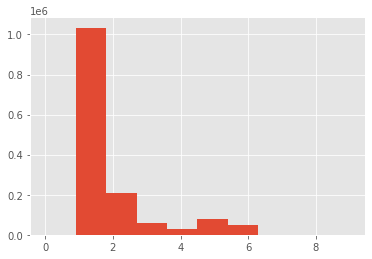

In [24]:
plt.hist(taxi_df['passenger_count']);

In [25]:
taxi_df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Nhận xét:
- Ta thấy phần lớn các chuyến đi sẽ có số lượng là 1 hành khách với 1033540 bản ghi, tiếp sau đó là 2 người với 210318 bản ghi. Đối với các chuyến đi có từ 3 đến 6 hành khách cũng có số lượng nhất định nằm trong khoảng từ 30000 đến 80000 bản ghi
- Ta cũng thấy có 60 chuyến đi với số lượng là 0 hành khách, đối với các chuyến có 7 8 9 hành khách cũng có rất ít bản ghi.

Vì tồn tại các dòng dữ liệu với các số liệu bất thường, đồng thời chúng cũng chiếm phần thiểu số trong tập dữ liệu, nên ta quyết định sẽ xóa bỏ các dòng có số lượng hành khách là 0, 7, 8 và 9 ra khỏi tập dữ liệu.

### Khảo sát cột **trip_duration** và **distance**

Trước tiên, ta xem qua biểu đồ boxplot của của cột trip_duration.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


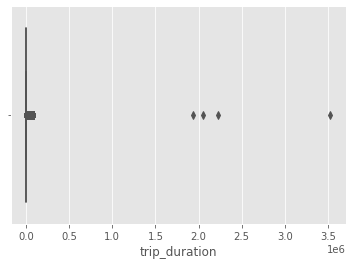

In [26]:
sns.boxplot(taxi_df['trip_duration'])

Nhận xét: Thông qua biểu đồ boxplot phía trên, ta có thể thấy thuộc tính trip_duration có các giá trị ngoại lai.

In [27]:
taxi_df["trip_duration"].sort_values(ascending=False)[:15]

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
1221666      86378
91717        86378
1138915      86377
66346        86377
1284067      86369
Name: trip_duration, dtype: int64

Nhận xét:
- Có 4 chuyến đi với với thời lượng di chuyển khá lớn từ gần 2 triệu giây đến hơn 3.5 triệu giây.
- Ngoài 4 chuyến đi với thời lượng di chuyển rất lớn ở phía trên, thì các chuyến đi còn lại trong tập dữ liệu của chúng ta sẽ có trip_duration không vượt quá 86400.

Tiếp theo, ta sẽ quan sát sự phân bố về số lượng các chuyến taxi có **trip_duration** nằm trong các khoảng (0-5000) giây, (5000, 10000), (10000, 80000), (80000, 82000), (82000, 83000), (83000, 84000) và (84000, 84600).

Text(0, 0.5, 'count')

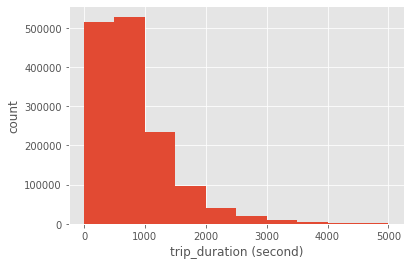

In [28]:
plt.hist(taxi_df['trip_duration'], range=(0, 5000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

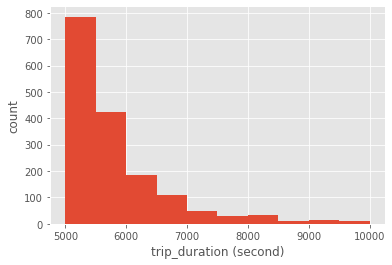

In [29]:
plt.hist(taxi_df['trip_duration'], range=(5000, 10000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

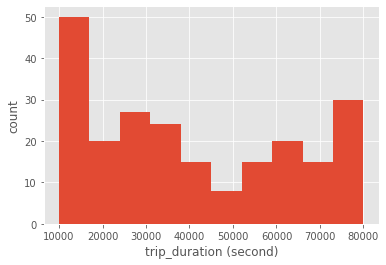

In [30]:
plt.hist(taxi_df['trip_duration'], range=(10000, 80000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

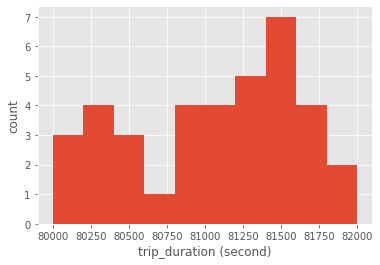

In [31]:
plt.hist(taxi_df['trip_duration'], range=(80000, 82000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

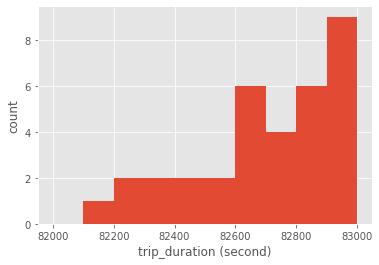

In [32]:
plt.hist(taxi_df['trip_duration'], range=(82000, 83000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

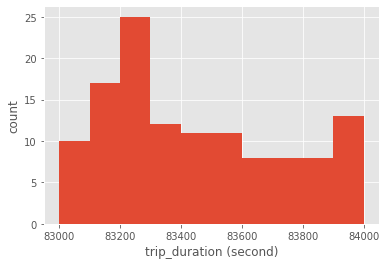

In [33]:
plt.hist(taxi_df['trip_duration'], range=(83000, 84000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

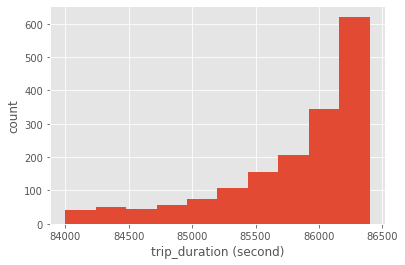

In [34]:
plt.hist(taxi_df['trip_duration'], range=(84000, 86400))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

**Nhận xét:**
- Các chuyến đi trong tập dữ liệu phần lớn có trip_duration từ 3000 giây trở về trước với số lượng bản ghi rất lớn so với các miền giá trị còn lại. Chỉ riêng với khoảng từ 0 tới 1000 giây đã có tới hơn 1 triệu bản ghi trong khi tập dữ liệu chỉ gần 1 triệu rưỡi dòng.
- Trong khoảng từ 7000 giây đến 86400 giây chúng ta có khá ít bản ghi mặc dù đây là một khoảng giá trị rất dài, dài hơn rất nhiều so với miền giá trị trước đó nhưng so về số lượng bản ghi thì ít hơn rất nhiều.
- Ta nhận thấy từ cột mốc 82600s trở lên thì số lượng bản ghi có xu hướng tăng. Đây là một khoảng giá trị trip_duration vô cùng lớn vì nó kéo dài tới xấp xỉ tới 40 ngày (quá dài so với 1 chuyến taxi thông thường trong một thành phố). Và ta cũng nhận thấy rằng khi thời lượng của trip_duration càng lớn thì số lượng bản ghi có xu hướng giảm đi. Điều này là hợp lý vì thời lượng của các chuyến taxi thường không dài đến thế và các chuyến đi này chỉ là thiểu số hoặc không tồn tại ở ngoài thực tế. Vì vậy, việc có nhiều chuyến taxi có trip_duration kéo dài tới xấp xỉ 40 ngày tăng lên bất ngờ như thế là một bất thường.

Ta cũng sẽ xem tốc độ và quãng đường của các chuyến đi có trip_duration >= 82600

(array([1.13e+03, 4.16e+02, 1.32e+02, 7.50e+01, 2.50e+01, 1.20e+01,
        4.10e+01, 1.90e+01, 0.00e+00, 1.00e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

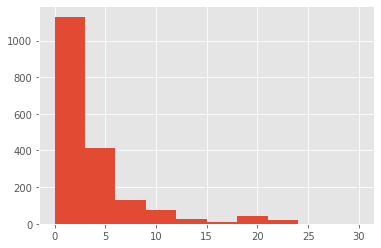

In [35]:
plt.hist(taxi_df[taxi_df['trip_duration'] >= 82600]['distance'], range=(0,30))

Ta nhận thấy tuy là có thời lượng di chuyển rất dài nhưng các chuyến đi này phần lớn đều di chuyển dưới 10km. Đây là một bất thường khá lớn.

(array([1.55e+03, 2.06e+02, 3.60e+01, 5.80e+01, 1.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([0.        , 0.25465655, 0.50931311, 0.76396966, 1.01862621,
        1.27328277, 1.52793932, 1.78259587, 2.03725243, 2.29190898,
        2.54656553]),
 <a list of 10 Patch objects>)

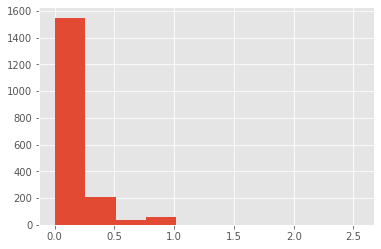

In [36]:
plt.hist(taxi_df[taxi_df['trip_duration'] >= 82600]['speed'])

Ngoài ra các chuyến đi này còn có tốc độ rất chậm khi tất cả đều có tốc độ dưới 1 km/h.

**Quyết định: Thông qua các khảo sát phía trên, ta quyết định xóa các chuyến đi có thuộc tính trip_duration lớn hơn 82600 giây.**

Ngoài các chuyến đi quá dài thì chúng ta cũng cần quan tâm đến các chuyến đi có độ dài quá ngắn. Dựa vào thông tin ở phần trước, chúng ta đã biết giá trị bé nhất của cột trip_duration là 1 giây nên vì vây ta sẽ tiến hành đếm số lượng các chuyến đi này.

In [37]:
taxi_df[taxi_df["trip_duration"] == 1].shape[0]


33

Mở rộng ra với các chuyến có độ dài bé hơn 120 giây:

In [38]:
taxi_df[taxi_df["trip_duration"] < 120].shape[0]

27817

Ta nhận thấy các chuyến xe dưới 2 phút có số lượng 27817 bản ghi, có thể các chuyến này là do khách hàng hủy chuyến hoặc khách hàng đổi ý khi xe chỉ mới vừa lăn bánh.

Tiếp theo, ta sẽ tiến hành xem thử khoảng cách di chuyển của các chuyến xe có trip_duration bé hơn 120 giây là bao nhiêu.

Text(0, 0.5, 'count')

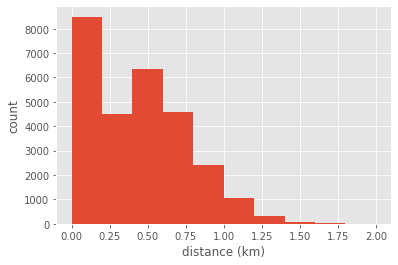

In [39]:
plt.hist(taxi_df[taxi_df['trip_duration'] < 120]['distance'], range=(0, 2))
plt.xlabel('distance (km)')
plt.ylabel('count')

Ta thấy phần lớn các chuyến đi dưới 120 giây đều có khoảng cách di chuyển bé hơn 1km, điều này là hợp lý bởi vì với một khoảng thời gian ngắn như thế thì sẽ không di chuyển được xa. Điều này cho thấy luận điểm khách hàng hủy chuyến hoặc đổi ý trong quá trình di chuyển là có cơ sở tin tưởng được.

Ta sẽ tiếp tục làm việc với các chuyến có quãng đường là 0km

In [40]:
distance_zero = taxi_df[taxi_df['distance'] == 0]
distance_zero.shape[0]

5897

Chúng ta có 5897 chuyến đi với khoảng cách là 0km

Ta tiếp tục xem thời lượng di chuyển của các chuyến có độ dài quãng đường bằng 0.

Text(0, 0.5, 'count')

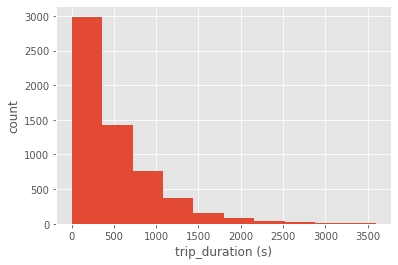

In [41]:
plt.hist(distance_zero['trip_duration'], range=(0, 3600))
plt.xlabel('trip_duration (s)')
plt.ylabel('count')

In [42]:
distance_zero[distance_zero['trip_duration'] < 120].shape[0]

1935

Như vậy là chúng ta có 1935 chuyến đi không di chuyển mà có trip_duration dưới 120 giây. Các chuyến còn lại có trip_duration trải dài từ 120 giây đến 3600 giây tương ứng với gần 1 giờ.

**Quyết định: Ta sẽ xóa các chuyến xe không di chuyển mà có trip_duration lớn hơn 120 giây và giữ lại các chuyến xe có trip_duration bé hơn 120 giây vì có thể các chuyến này bị hủy bởi khách hàng khi xe chưa di chuyển.**

### Khảo sát cột **speed**

In [43]:
taxi_df["speed"].sort_values(ascending=False)[:20]

1176337    9279.581773
910072     6874.214785
184925     5638.682980
974378     5253.665463
377068     4090.789812
1013474    1760.893664
923793     1442.634083
906281     1410.612913
1001028    1408.750365
595540     1355.140122
275644     1292.957998
1107       1266.014753
898154     1243.162682
644165     1137.259158
777670     1094.027657
283102      951.259095
1322903     928.984704
1200843     912.431995
259403      910.453922
467645      835.257183
Name: speed, dtype: float64

(array([117899., 535641., 448293., 203574.,  85587.,  37724.,  18034.,
          7682.,   2679.,    844.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

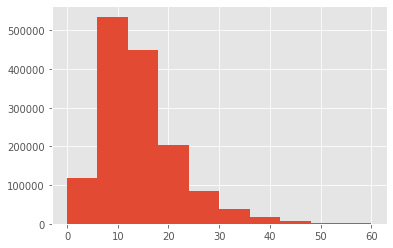

In [44]:
plt.hist(taxi_df["speed"], range=(0, 60))

In [45]:
number_of_under_60_speed = taxi_df[taxi_df["speed"] <= 100].shape[0]
number_of_under_60_speed

1458469

Ta thấy phần lớn các chuyến xe đều có tốc dộ di chuyển dưới 100km/h với tổng số 1.452.089 bản ghi. Đây là một tốc độ bình thường đối với các chuyến taxi trong thành phố.

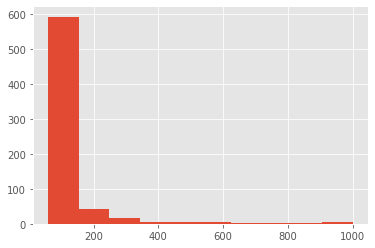

In [46]:
plt.hist(taxi_df["speed"], range=(60, 1000));

Đối với các chuyến xe có tốc độ di chuyển từ 60km/h trở lên không chiếm số lượng nhiều, trong đó tốc độ từ 60km/h đến 100km/h chiếm phần lớn.

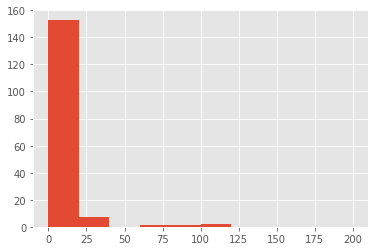

In [47]:
plt.hist(taxi_df[taxi_df['speed'] >=100]['distance'], range=(0,200));

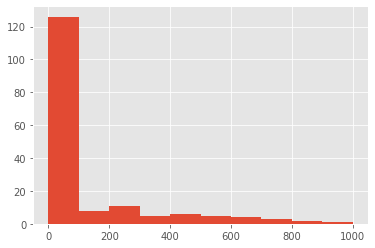

In [48]:
plt.hist(taxi_df[taxi_df['speed'] >=100]['trip_duration'], range=(0, 1000));

**Quyết định: Xóa các chuyến đi có tốc độ di chuyển lớn hơn 100km/h**

## Tiền xử lý dữ liệu (tiếp theo)

### Xóa các bản ghi có passenger_count = 0, 7, 8, 9

In [49]:
taxi_df.drop(taxi_df[taxi_df['passenger_count'].isin([0, 7, 8, 9])].index, inplace = True)

### Xóa các chuyến có trip_duration lớn hơn 82600

In [50]:
taxi_df.drop(taxi_df[taxi_df['trip_duration'] > 82600].index, inplace = True)

### Xóa các chuyến có distance = 0 và trip_duration lớn hơn 120 giây

In [51]:
distance_zero = taxi_df[taxi_df['distance'] == 0]
taxi_df.drop(distance_zero[distance_zero['trip_duration'] > 120].index, inplace=True)

### Xóa các chuyến có tốc độ di chuyển từ 100km/h trở lên.

In [52]:
taxi_df.drop(taxi_df[taxi_df['speed'] >= 100].index, inplace = True)

In [53]:
taxi_df.reset_index(drop=True, inplace=True)

In [54]:
taxi_df.shape[0]

1452600

## Khám phá dữ liệu (tiếp tục)

Với mỗi cột có kiểu dữ liệu dạng categorical, các giá trị được phân bố như thế nào?

vendor_id và store_and_flag là 2 cột có kiểu dữ liệu dạng categorical.

vendor_id : mã cho biết nhà cung cấp được liên kết với hồ sơ chuyến đi.

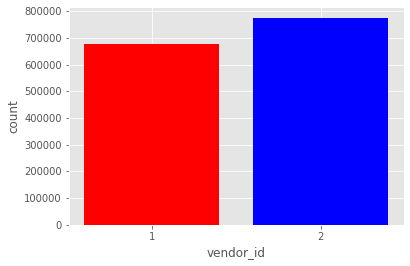

In [55]:
vendor_counts = taxi_df['vendor_id'].value_counts(ascending=True)
plt.bar(vendor_counts.index, vendor_counts.values, color=['red', 'blue'])
plt.xlabel('vendor_id')
plt.ylabel('count');

Dựa vào biểu đồ trên ta thấy Vendor 2 cung cấp nhiều hơn Vendor 1 khoảng 100K bản ghi.

In [56]:
vendor_counts

1    677432
2    775168
Name: vendor_id, dtype: int64

So sánh sự khác biệt giữa Vendor_id 1 và Vendor_id 2.

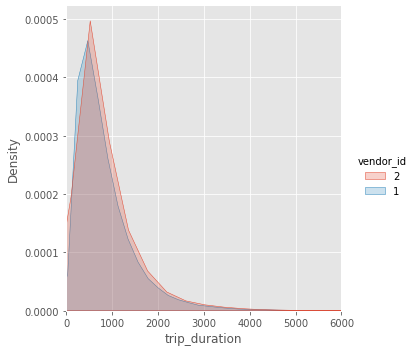

In [57]:
sns.displot(taxi_df[:300000] , x='trip_duration',kind="kde", hue='vendor_id', fill=True)
plt.xlim(-10, 6000);

Nhận thấy sự khác biệt giữa  Vendor_id 1 và Vendor_id 2 là không đáng kể.

Khám phá cột store_and_fwd_flag 

In [58]:
(taxi_df['store_and_fwd_flag'] == True).mean()*100

0.5519069255128735

Khoảng 0.55% các chuyến có bản ghi được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp.


Ta tiếp tục tìm hiểu mối liên hệ của nó với trip_duration.

Text(0, 0.5, 'densityfc')

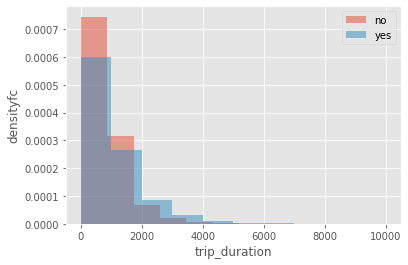

In [59]:
store_no = taxi_df[~taxi_df['store_and_fwd_flag']]['trip_duration']
store_yes = taxi_df[taxi_df['store_and_fwd_flag']]['trip_duration']
plt.hist(store_no[:100000],range=(2.00000e+00, 8.63750e+03), label='no', density=True, alpha=0.5)
plt.hist(store_yes, label='yes', density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('trip_duration')
plt.ylabel('densityfc')

Dựa vào biểu đồ trên, ta nhận thấy sự khác biệt không đáng kể. Vì vậy sẽ không khám phá thêm về thuộc tính này.

## Phân tích dữ liệu



Target của bài toán là trip_duration nên nhóm mình đặt ra các câu hỏi về ảnh hưởng của thời gian và địa điểm của điểm đón/trả liệu có ảnh hưởng đến trip_duration. Trên thực tế, thời gian và địa điểm có ảnh hưởng đến độ dài chuyến đi, có thể vào giờ cao điểm ở một số khu vực sẽ bị di chuyển chậm hơn bình thường. Để trả lời cho các giả thuyết này, nhóm mình sẽ cần trả lời các câu hỏi sau:

**Question1:** Trip_duration thay đổi như thế nào theo các ngày trong tuần và các giờ trong ngày? \

Chúng ta sẽ chia làm 3 khung giờ:


1.   Giờ cao điểm: số lượt pickup(đón 
khách) cao.
2.   Giờ bình thường: số lượt pickup(đón khách) trung bình.
3.   Giờ thấp điểm: Số lượt pickup(đón khách) thấp.

Tạo Dataframe chứa thông tin về thời gian pickup




In [80]:
time_pickup = pd.DataFrame()
time_pickup['Month'] = taxi_df['pickup_datetime'].dt.month
time_pickup['Weekday'] = taxi_df['pickup_datetime'].dt.weekday
time_pickup['Hour'] = taxi_df['pickup_datetime'].dt.hour
time_pickup['Week'] = taxi_df['pickup_datetime'].dt.isocalendar().week
time_pickup['Distance'] = taxi_df['distance']
time_pickup['Trip_duration'] = taxi_df['trip_duration']
time_pickup.shape[0]

1452600

trong đó:


*   Month tương ứng với tháng.
*   Weekday: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday được gán nhãn tương ứng từ 0 tới 6.
*   Hour: Giờ trong ngày.
*   Week: Thứ tự tuần trong năm.
*   distance: Khoảng cách.
*   trip_duration: Thời gian xe chạy.







In [79]:
time_pickup['Week'].value_counts(sort=True, ascending=True)

53    19931
26    29640
3     45101
21    52099
1     52965
22    53540
25    53847
24    53860
4     53989
23    55030
12    55300
16    55593
5     55905
17    56628
2     56698
7     56938
13    57234
19    57355
10    57588
20    58195
8     58283
6     58830
11    58943
18    59301
9     59428
15    59805
14    60574
Name: Week, dtype: Int64

Ta nhận thấy ở tuần thứ 26 và 53 thì lượng bản ghi thấp hơn các tuần còn lại rất nhiều, tương ứng với 19931 bản ghi ở tuần 26 và 29640 ở tuần 53. Ta sẽ tìm hiểu lý do ở phần kế tiếp.

In [84]:
# drop weekday = 26 or 53 do không đủ 7 ngày
time_pickup_per_week=time_pickup.copy()
#time_pickup_per_week = time_pickup_per_week.drop(time_pickup[time_pickup['Week'] == 26].index)
#time_pickup_per_week = time_pickup_per_week.drop(time_pickup[time_pickup['Week'] == 53].index)

Tìm kiếm khung giờ nào là cao điểm,trung bình,thấp điểm.

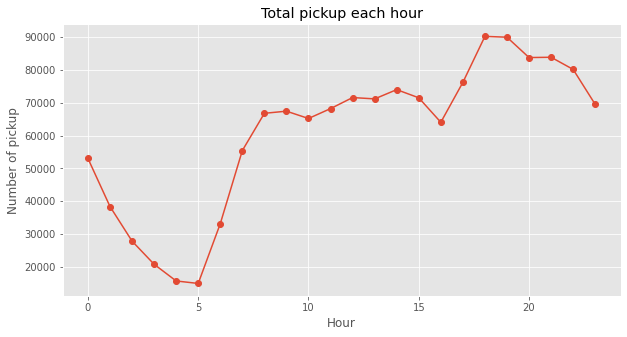

In [85]:
time_pickup.groupby(['Hour']).size().plot(kind='line', title='Total pickup each hour', figsize=(10, 5),ylabel='Number of pickup',marker='o')

Dựa vào đồ thị trên, trong 6 tháng thì:


*   Giờ cao điểm nằm trong khoảng 18-23h
*   Giờ bình thường nằm trong khoảng 8-17h
*   Giờ thấp điểm nằm trong khoảng 0-7h






Thời gian pickup theo từng tuần và từng tháng.

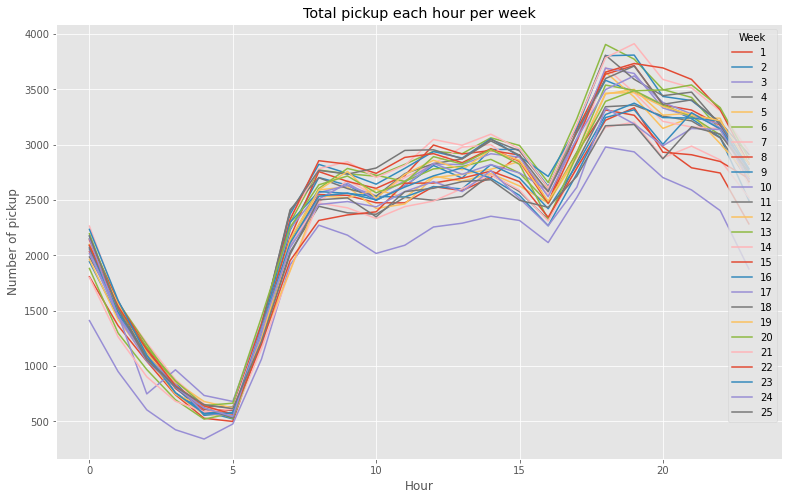

In [86]:
time_pickup_per_week.groupby([ 'Hour','Week']).size().unstack().plot(kind='line', title='Total pickup each hour per week', figsize=(13, 8), legend=True,ylabel='Number of pickup')

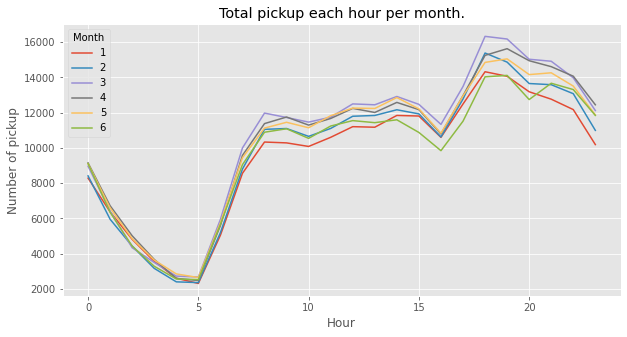

In [87]:
time_pickup.groupby(['Hour', 'Month']).size().unstack().plot(kind='line', title='Total pickup each hour per month.', figsize=(10, 5), legend=True,ylabel='Number of pickup')

Dựa vào 2 đồ thị trên ta có thể thấy các tháng và các tuần trong dữ liệu gần như tương tự nhau. Ngoại lệ có 2 tuần hơi khác đó là 26 và 53 khi mà 2 tuần này là 2 tuần đầu và cuối của dữ liệu nên số ngày không đủ dẫn đến số lượng pickup thấp.

Kết luận:


*  Giờ cao điểm nằm trong khoảng 18-23h.
*  Giờ bình thường nằm trong khoảng 8-17h.
*  Giờ thấp điểm nằm trong khoảng 0-7h.






Tìm xem trong tuần thứ mấy thường xuyên pickup.

[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

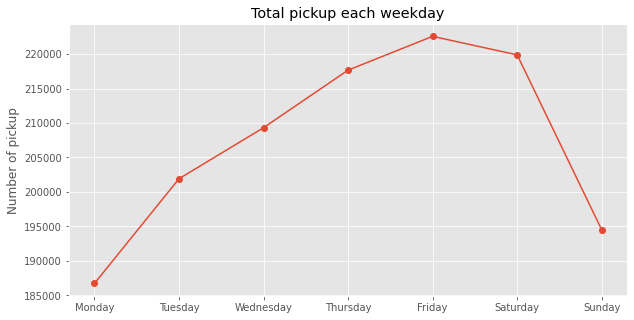

In [64]:
fig, ax = plt.subplots()
fig=time_pickup['Weekday'].value_counts().sort_index().plot(kind='line',figsize=(10,5),marker='o',title='Total pickup each weekday',ylabel='Number of pickup')
ax.set_xticklabels(["",'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Dựa vào đồ thị, ta có thể đưa ra giả thuyết rằng: trong 7 ngày trong tuần thì có 2 ngày có lượt pickup thấp là ngày thứ 2 và ngày Chủ nhật.

Để củng cố thêm giả thuyết thì chúng ta sẽ bắt đầu xem visualize các tuần để xác nhận thấy có sự khác biệt không.
Ở đây xtick label= 0, 1, 2, 3, 4, 5, 6 do index của dataframe là multi của weekday và week nên không set được weekday:


*   0: Monday
*   1: Tuesday
*   2: Wednesday
*   3: Thursday
*   4: Friday
*   5: Saturday
*   6: Sunday


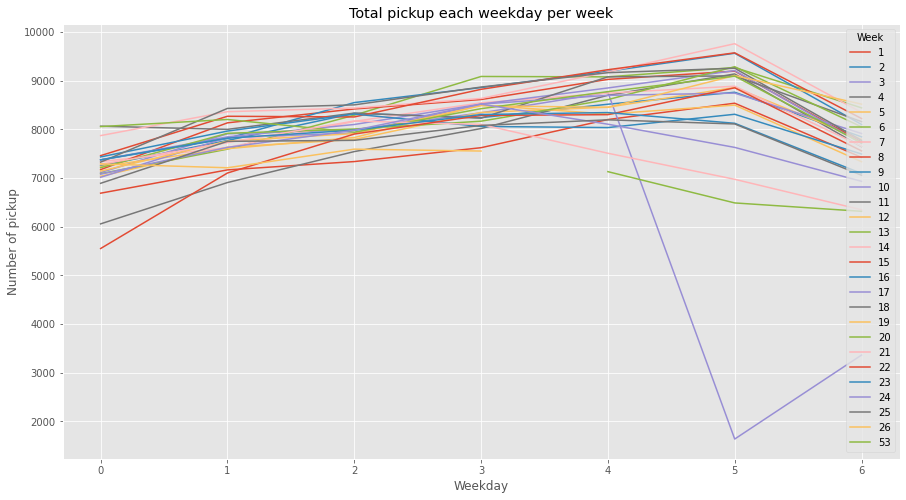

In [65]:
time_pickup_per_week.groupby(['Weekday', 'Week']).size().unstack().plot(kind='line', title='Total pickup each weekday per week', figsize=(15, 8), legend=True,ylabel='Number of pickup')

Dựa vào đồ thị trên, thứ 7 của một tuần nào đó đón khách rất ít. Ta sẽ tìm hiểu.

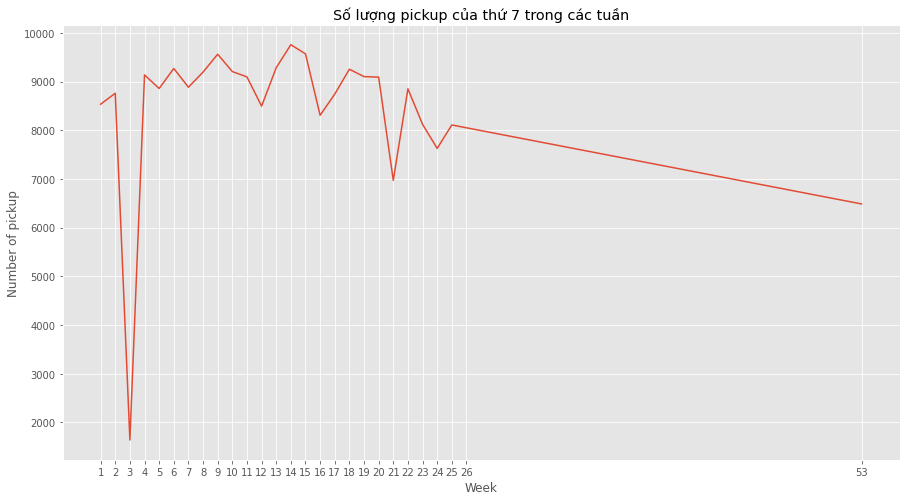

In [66]:
fig, ax = plt.subplots()
fig=time_pickup_per_week[time_pickup_per_week['Weekday'] == 5].groupby(["Week"]).size().plot(kind='line', title='Số lượng pickup của thứ 7 trong các tuần', figsize=(15, 8),ylabel='Number of pickup',xticks=time_pickup_per_week.Week.value_counts().sort_index().index)

Dựa vào đồ thị, ta thấy vào thứ 7 của tuần thứ 3 năm 2016 số lượng pickup rất thấp nguyên nhân do bão tuyết vào hôm đó. Vậy ta biết được thêm một yếu tố ảnh hưởng tới pickup là thời tiết.

Kết luận:


*   Số lượng pickup theo chu kỳ như sau: pickup ở mức thấp vào cuối tuần(Chủ Nhật) và đầu tuần(Thứ 2), sau đó tăng dần lên đỉnh điểm vào thứ 6 hoặc 7 và giảm xuống vào Chủ Nhật.
*   Số lượng pickup phụ thuộc vào thời tiết, khi mà có sự kiện thời tiết cực đoan thì số lượng pickup sẽ giảm.



Đánh giá về Trip Duration đối với mỗi khung giờ và theo các ngày trong tuần

[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

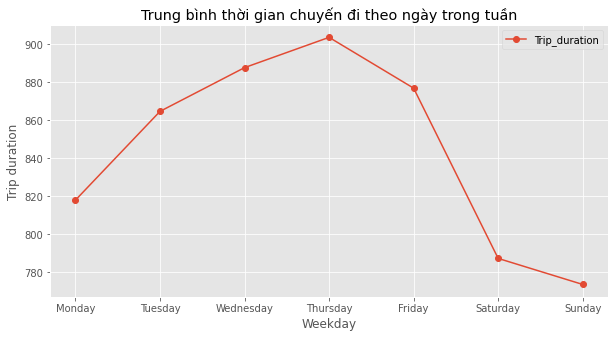

In [67]:
# Trip duration
fig, ax = plt.subplots()
fig=time_pickup.groupby(["Weekday"])["Trip_duration"].mean().plot(kind='line', title='Trung bình thời gian chuyến đi theo ngày trong tuần', figsize=(10, 5), legend=True,ylabel='Trip duration',marker='o')
ax.set_xticklabels(["",'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Dựa vào đồ thị,thời gian trung bình chuyến đi ở mức cao ở giữa tuần và thấp hơn đáng kể vảo ngày thứ 7 và Chủ nhật. Ta có thể đưa ra giả thuyết là cuối tuần, ít người đi làm sẽ khiến do các chuyến đi nhanh hơn, hoặc vào ngày cuối tuần các chuyển đi sẽ ngắn hơn, tiết kiệm thời gian hơn.

Ta sẽ tìm hiểu vận tốc giữa các khung giờ như thế nào.

Text(0, 0.5, 'Distance')

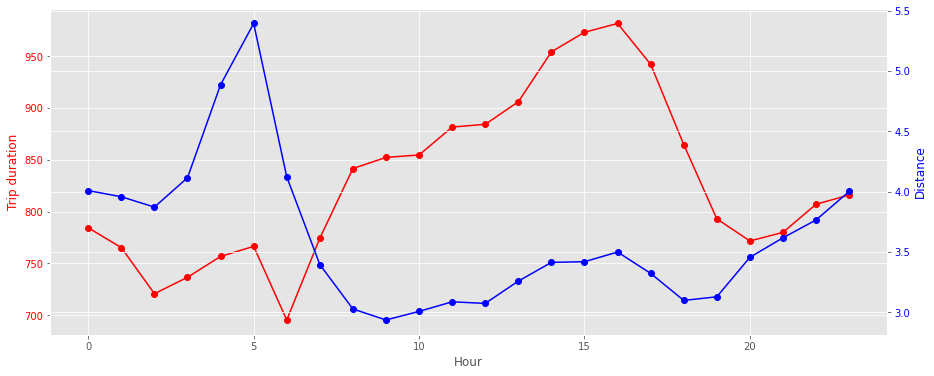

In [68]:
# Trip duration
fig, ax =plt.subplots(1,figsize=(15,6))
plt.xlabel('Hour')
plt.ylabel('Trip duration',color="r")
plt.plot(list(time_pickup.groupby(["Hour"])["Trip_duration"].mean().index),
        list(time_pickup.groupby(["Hour"])["Trip_duration"].mean().values),"r",marker="o")
plt.tick_params(axis="y", labelcolor="r")
plt.twinx()
plt.plot(list(time_pickup.groupby(["Hour"])["Distance"].mean().index),
        list(time_pickup.groupby(["Hour"])["Distance"].mean().values),"b",marker="o")
plt.tick_params(axis="y", labelcolor="b")
plt.ylabel('Distance',color="b")

Thì đáng lẽ trong khung giờ cao điểm, số lượng pickup nhiều thì thời gian lâu hơn. Nhưng ở đây lại nhanh hơn giờ bình thường và tiệm cận giờ thấp điểm.

Ta có thể thấy:

Ở khung giờ cao điểm 18-23h: Khoảng cách di chuyển cao hơn khung giờ bình thường nhưng lại di chuyển nhanh => Mật độ giao thông thấp, di chuyển nhanh.
Ở khung giờ bình thường 8-17h: Khoảng cách di chuyển thấp nhưng di chuyển rất chậm. => Mật độ giao thông rất cao, có thể là kẹt xe.
Ở khung giờ thấp điểm 0-7h: Khoảng cách di chuyển cao nhất, thời gian di chuyển cũng nhanh nhất => Mật độ giao thông thưa thớt.

Để củng cố thêm giả thuyết thì chúng ta sẽ xem heatmap của vận tốc

In [69]:
time_pickup['Speed'] = time_pickup['Distance']/(time_pickup['Trip_duration']/3600)# convert to km/h

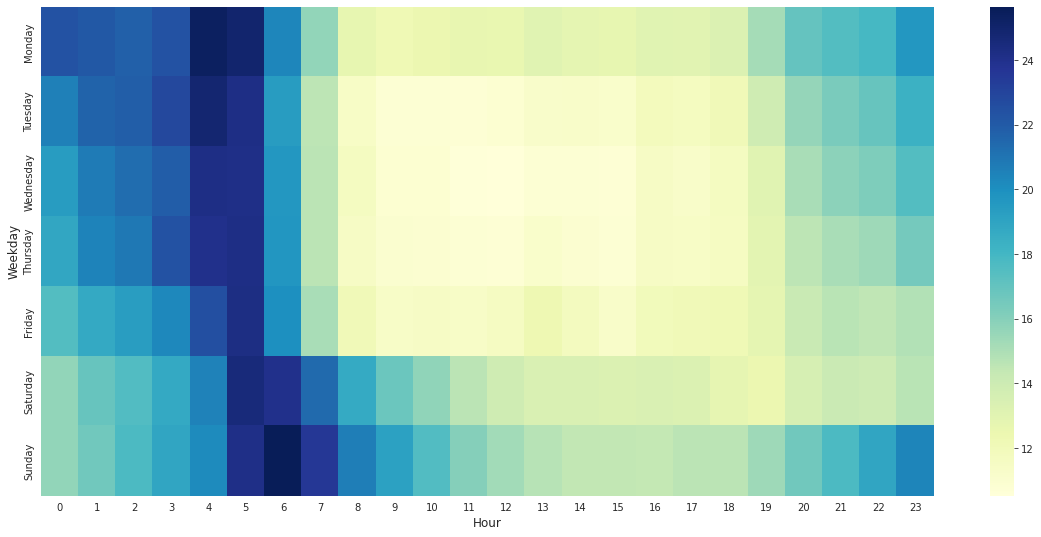

In [70]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 9))
    ax = sns.heatmap(time_pickup.groupby(["Weekday","Hour"])["Speed"].mean().unstack(),cmap="YlGnBu")
    ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Chúng ta có thể thấy trong thời điểm từ 0-7h thì vận tốc trung bình sẽ cao hơn các khung giờ khác.
Quyết định: Thêm 1 feature mới là "Low_Speed_Time" vào dataset. Với giá trị là 1 nếu khung giờ là 8-18h từ thứ 2 đến thứ 6

In [71]:
def Low_Speed_Time_func(Date):
    if Date.weekday() in [0,1,2,3,4]:
        if Date.hour in range(8,18):
            return 1
        else:
            return 0
    else:
        return 0
# add feature
taxi_df["Low_speed_time"]= taxi_df["pickup_datetime"].apply(lambda x : Low_Speed_Time_func(x))

Dựa vào các phân tích ở trên ta trả lời cho Question 1 như sau:


*   Hành khách thường ít pickup taxi vào ngày đầu tuần và ngày cuối tuần.
*   Các ngày giữa tuần như Thứ 6, thứ 7 được nhiều lượt pickup hơn so với các ngày còn lại.
*   Thời tiết cực đoan ảnh hưởng rất lớn đến số lượng pickup.
*   Các chuyến đi ở khung giờ (0-7h) là những chuyến đi dài với tốc độ nhanh nhất so với khung giờ khác.
*   Các chuyến đi ở khung giờ (8-17h) là những chuyến đi ngắn với tốc độ chậm.
*   Các chuyến đi ở khung giờ (18-23h) là những chuyến đi ngắn với tốc độ nhanh.







**Q2.** Vị trí địa lý của các điểm đón/trả có ảnh hưởng đến trip_duration không? 

Ta tạm định nghĩa chuyến dài là những chuyến có distance lớn hơn 50km. Điều này ta có thể quan sát phân bố của distance và trên thực tế đi vòng quanh New York City cần đi 30 miles (48.28km).

Trong phần này có sử dụng các thư viện ngoài chương trình học để hỗ trợ tính toán và visualize:


*   geopy để tính toán khoảng cách theo đường chim bay giữa 2 điểm dựa vào tọa độ
*   folium để visualize bản đồ





In [72]:
short_trips = taxi_df[taxi_df['distance'] <= 50][:300]
long_trips = taxi_df[taxi_df['distance'] > 50]

In [73]:
#Khởi tạo bản đồ focus tại New York City
nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles='Stamen Terrain')
nyc_geo = r'cant find specific file'

folium.Choropleth(
    geo_data=nyc_geo,
    columns=['Country','Total'],
    key_on='features.properties.objectid',
    fill_color='YlOrRd', 
    fill_opacity=0, 
    line_opacity=0.5,
    line_color='blue',
    legend_name='New York City'
).add_to(nyc_map)

#Vẽ các điểm đón (màu xanh)
short_trip_points = folium.map.FeatureGroup()
for lat, lng, in zip(short_trips.pickup_latitude, short_trips.pickup_longitude):
    short_trip_points.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6
            )
        )

#Vẽ các điểm trả (màu đỏ)
for lat, lng, in zip(short_trips.dropoff_latitude, short_trips.dropoff_longitude):
    short_trip_points.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                color='yellow',
                fill=True,
                fill_color='red',
                fill_opacity=0.6
            )
        )

FileNotFoundError: ignored